# Logistic Regression

In [0]:
import numpy as np
from sklearn.exceptions import NotFittedError
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap

## **Mathematical expression of the algorithm**:

For one example $x^{(i)}$:

Compute Linear Regression: $z^{(i)} = w^T x^{(i)} + b \tag{1}$
Pass it through the activation function: $\hat{y}^{(i)} = a^{(i)} = \frac{1}{1 + e^{z^{(i)}}}\tag{2}$
We will use log-loss as a loss function:

$$\mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J(w, b) = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{4}$$

Here is the formula for gradient: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{5}$$

In [0]:
class LogisticRegression:
    def __init__(self, max_iters=500, learning_rate=.01,
                 validation=None, fit_intercept=False, print_loss=True,
                 print_per_n_iter=5, early_stoping=20, epsilon=10e-5):
        self.max_iters = max_iters
        self.learning_rate = learning_rate
        self.loss_history = []
        self.coef_history = []
        self.fit_intercept = fit_intercept
        if validation is not None:
            self.validation = True
            self.val_loss_history = []
            self.val_X = self._add_intercept(validation[0])
            self.val_Y = validation[1]
        else:
            self.validation = False
        self.print_loss = print_loss
        self.print_per_n_iter = print_per_n_iter
        self.early_stoping = early_stoping
        self.epsilon = epsilon
        self.n_unchanged_steps = 0
    
    def _add_intercept(self, X):
        if self.fit_intercept:
            return np.column_stack((np.ones(len(X)), X))
        return X
    
    def _update(self, mse):
        self.coef_history.append(self.coef_.flatten())
        self.loss_history.append(mse)
        if self.validation is not None:
            test_cost = self.cost(self.val_X, self.val_Y)
            self.val_loss_history.append(test_cost)
            
    def _check_loss(self):
        if self.validation:
            if (abs(self.val_loss_history[-1] - self.val_loss_history[-2]) < self.epsilon) or \
            (self.val_loss_history[-1] - self.val_loss_history[-2] > 0):
                self.n_unchanged_steps += 1
                if self.n_unchanged_steps == self.early_stoping:
                    self.coef_ = self.coef_history[np.argmin(self.val_loss_history)]
                    return True
            else:
                self.n_unchanged_steps = 0
                return False
        else:
            if abs(self.loss_history[-1] - self.loss_history[-2]) < self.epsilon or \
            self.loss_history[-1] - self.loss_history[-2] > 0:
                self.n_unchanged_steps += 1
                if self.n_unchanged_steps == self.early_stoping:
                    return True
            else:
                self.n_unchanged_steps = 0
                return False
        
    def activation(self, X):
        return 1 / (1 + np.exp(-np.dot(X, self.coef_)))

    def cost(self, X, Y):
        return - 1/len(X) * ( np.sum(Y * np.log(self.activation(X))) + np.sum((1 - Y) * np.log(1 - self.activation(X))))
    
    def fit(self, X, Y):
        X_train = self._add_intercept(X)
        Y_train = Y.reshape(-1, 1)
        n_samples, n_features = X_train.shape
        self.coef_ = np.zeros((n_features, 1))
        
        for i in range(self.max_iters):
            
            if self.coef_.shape != (n_features, 1):
                self.coef_ = self.coef_.reshape(n_features, 1)
                
            # Gradient
            grad = 1 / n_samples * np.matmul(X_train.T, self.activation(X_train) - Y_train)
            
            # Update weights
            self.coef_ -= grad * self.learning_rate
            
            cost =  self.cost(X_train, Y_train)
            # Update history
            self._update(cost)
            if self.print_loss and i % self.print_per_n_iter == 0:
                if self.validation:
                    print ("%4i epoch: train_cost - %10.3f, test_cost - %10.3f" %(i, self.loss_history[-1], self.val_loss_history[-1]))
                else:
                    print ("%4i epoch: train_cost - %10.3f" %(i, self.loss_history[-1]))
            if i >= 1 and self._check_loss():
                break
        return self
    
    def predict(self, X):
        X_pred = self._add_intercept(X)
        try:
            activation = self.activation(X_pred)
        except AttributeError:
            msg = "This %s instance is not fitted yet."
            raise NotFittedError(msg % self.__class__.__name__)
        return np.where(activation > 0.5, 1, 0) 

In [0]:
# Generating the data
def generate_data(**kwargs):
    X_data, Y_data = make_classification(**kwargs, )
    Y_data = Y_data.reshape(-1,1)
    return train_test_split(X_data, Y_data, test_size=0.25, random_state=42), (X_data, Y_data)

(train_set_x, test_set_x, train_set_y, test_set_y), (X_data, Y_data) = \
generate_data(n_samples=1000,
              n_features=2,
              n_informative=2,
              n_redundant=0,
              class_sep=1,
              n_clusters_per_class=2,
              random_state=3)

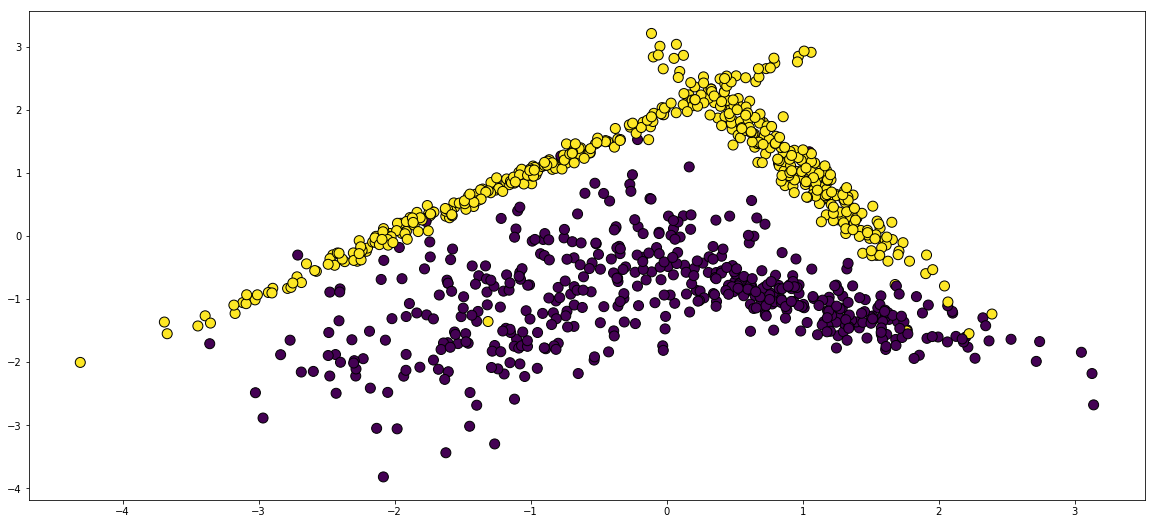

In [269]:
figure, axis = plt.subplots(figsize=(20,9))
plt.scatter(X_data[:,0], X_data[:,1], c = Y_data.flatten(),
            edgecolor='black', s=100)
plt.show()

In [0]:
colors = ListedColormap(['red','green','blue'])
light_colors = ListedColormap(['lightcoral','lightgreen','lightblue'])

def get_meshgrid(data, step=.05, border=.5):
    xmin, xmax = data[:,0].min()-border, data[:,0].max()+border
    ymin, ymax = data[:,1].min()-border, data[:,1].max()+border
    return np.meshgrid(np.arange(xmin, xmax, step), np.arange(ymin, ymax, step))

def plot_decision_surface(estimator, train_data, test_data, train_labels, test_labels, 
                          colors=colors, light_colors=light_colors):
    dimentions = len(train_data[0])
    xx, yy = get_meshgrid(train_data)    
    cls_input = []
    for x, y in zip(xx.ravel(),yy.ravel()):
        sample = [x,y]
        sample.extend([0]*(dimentions-2))
        cls_input.append(sample)
    
    plt.figure(figsize=(20,9))
    # Plot decision surface on train data
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = estimator.predict(np.array(cls_input)).reshape(xx.shape)
    plt.pcolormesh(xx,yy,mesh_predictions,cmap=light_colors)
    plt.scatter(train_data[:,0], train_data[:,1], c=train_labels.flatten(), cmap=colors, s=100)    
    train_accuracy = accuracy_score(train_labels, estimator.predict(train_data))
    plt.title("Train data accuracy {:.2f}".format(train_accuracy))
    plt.xlim(train_data[:,0].min(),train_data[:,0].max())
    plt.ylim(train_data[:,1].min(),train_data[:,1].max())
    
    # Plot decision surface on test data
    plt.subplot(1,2,2)
    plt.pcolormesh(xx,yy,mesh_predictions,cmap=light_colors)
    plt.scatter(test_data[:,0], test_data[:,1], c=test_labels.flatten(), cmap=colors, s=100)    
    test_accuracy = accuracy_score(test_labels, estimator.predict(test_data))
    plt.title("Test data accuracy {:.2f}".format(test_accuracy))
    plt.xlim(train_data[:,0].min(),train_data[:,0].max())
    plt.ylim(train_data[:,1].min(),train_data[:,1].max())

In [220]:
regressor = LogisticRegression(validation=(test_set_x, test_set_y), print_per_n_iter=50)
regressor.fit(train_set_x, train_set_y)

   0 epoch: train_cost -      0.691, test_cost -      0.691
  50 epoch: train_cost -      0.594, test_cost -      0.596
 100 epoch: train_cost -      0.528, test_cost -      0.532
 150 epoch: train_cost -      0.482, test_cost -      0.488
 200 epoch: train_cost -      0.448, test_cost -      0.457
 250 epoch: train_cost -      0.423, test_cost -      0.433
 300 epoch: train_cost -      0.403, test_cost -      0.415
 350 epoch: train_cost -      0.387, test_cost -      0.401
 400 epoch: train_cost -      0.375, test_cost -      0.390
 450 epoch: train_cost -      0.364, test_cost -      0.381


## Result visualization of simple logistic regression

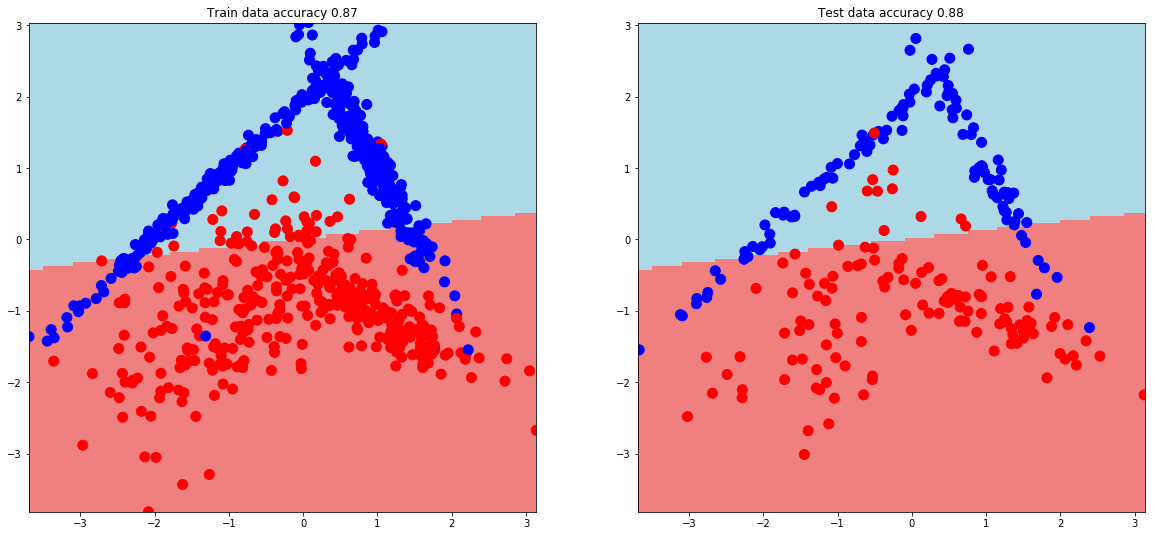

In [221]:
plot_decision_surface(regressor, train_set_x, test_set_x, train_set_y, test_set_y)

In [0]:
class PolynomialFeatures:
    def __init__(self, degree=2, include_bias=True):
        self.degree = degree
        self.include_bias = include_bias

    def fit(self, X: np.ndarray, *args):
        # (1, 2) => [(1),(2),(1,1),(1,2),(2,2)]
        n_samples, n_features = X.shape
        combs = [combinations_with_replacement(range(n_features), i) for i in range(0, self.degree + 1)]
        # combs = [(),((1),(2)),((1,1),(1,2),(2,2))]
        flat_combs = [item for sublist in combs for item in sublist if item]
        # flat_combs = [(1),(2),(1,1),(1,2),(2,2)]
        self.combinations = flat_combs
        return self
        
    def transform(self, X: np.ndarray, *args) -> np.ndarray:
        """
        Transform data to polynomial features
        """
        n_samples, n_features = X.shape

        try:
            X_new = np.empty(shape=(n_samples, len(self.combinations)))
        except AttributeError:
            msg = "This %s instance is not fitted yet."
            raise NotFittedError(msg % self.__class__.__name__)
        else:
            for i in range(n_samples):
                for j, index_combs in enumerate(self.combinations):
                    X_new[i,j] =  np.prod(X[i, index_combs])
            if self.include_bias:
                return np.column_stack((np.ones(len(X_new)),X_new))
            return X_new
    
    def fit_transform(self, X: np.ndarray, *args):
        return self.fit(X).transform(X)

In [0]:
from itertools import combinations_with_replacement
from sklearn.pipeline import Pipeline

In [0]:
feature_generator = PolynomialFeatures(degree=4, include_bias=False)
val_X = feature_generator.fit_transform(test_set_x)
val_Y = test_set_y

In [0]:
model = Pipeline((
    ('feature generator', feature_generator),
    ('regressor', LogisticRegression(validation=(val_X, val_Y), print_per_n_iter=50))
))

In [260]:
model.fit(train_set_x, train_set_y)

   0 epoch: train_cost -      0.657, test_cost -      0.654
  50 epoch: train_cost -      0.384, test_cost -      0.364
 100 epoch: train_cost -      0.326, test_cost -      0.307
 150 epoch: train_cost -      0.295, test_cost -      0.276
 200 epoch: train_cost -      0.275, test_cost -      0.255
 250 epoch: train_cost -      0.260, test_cost -      0.240
 300 epoch: train_cost -      0.249, test_cost -      0.229
 350 epoch: train_cost -      0.240, test_cost -      0.220
 400 epoch: train_cost -      0.233, test_cost -      0.212
 450 epoch: train_cost -      0.228, test_cost -      0.206


Pipeline(memory=None,
     steps=[('feature generator', <__main__.PolynomialFeatures object at 0x7f410f86d550>), ('regressor', <__main__.LogisticRegression object at 0x7f410f86d160>)])

## Result visualization of polynomial logistic regression

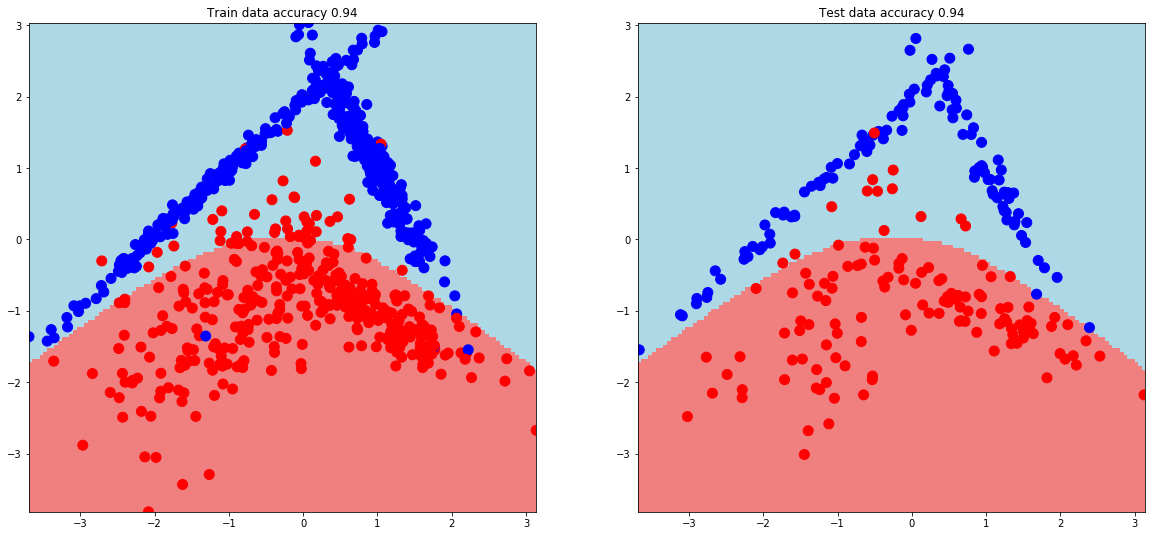

In [261]:
plot_decision_surface(model, train_set_x, test_set_x, train_set_y, test_set_y)

In [0]:
def plot_loss(regressor, axis):
    cmap = plt.get_cmap('viridis')
    loss = regressor.loss_history
    axis.plot(loss, color=cmap(0.9), linewidth=3,
              label=f'Train loss ({regressor.loss_history[-1]:.3f})')
    try:
        val_loss = regressor.val_loss_history
    except AttributeError:
        pass
    else:
        axis.plot(val_loss, color=cmap(0.5), linewidth=3,
                  label=f'Test loss ({regressor.val_loss_history[-1]:.3f})')
    axis.set_title('Loss function', fontsize=18)
    axis.set_xlabel('Epochs', fontsize=14)
    axis.legend(fontsize=14)
    
def plot_weigth(weight_history, axis, feature_names=None, legend=True):
    weight_history = np.array(weight_history)
    if feature_names:
        labels = ['bias'] + feature_names 
    else:
        labels = ['bias'] + [f'feature {i}' for i in range(weight_history.shape[1] - 1)]
    
    for i, weight in enumerate(weight_history.T):
        color = np.random.uniform(size=3)
        axis.plot(weight_history[:, i], color=color, linewidth=3,
                  label=f'{labels[i]} ({weight_history[-1,i]:.2f})')
    axis.set_title('Weight History', fontsize=18)
    axis.set_xlabel('Epochs', fontsize=14)
    if legend:
        axis.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))

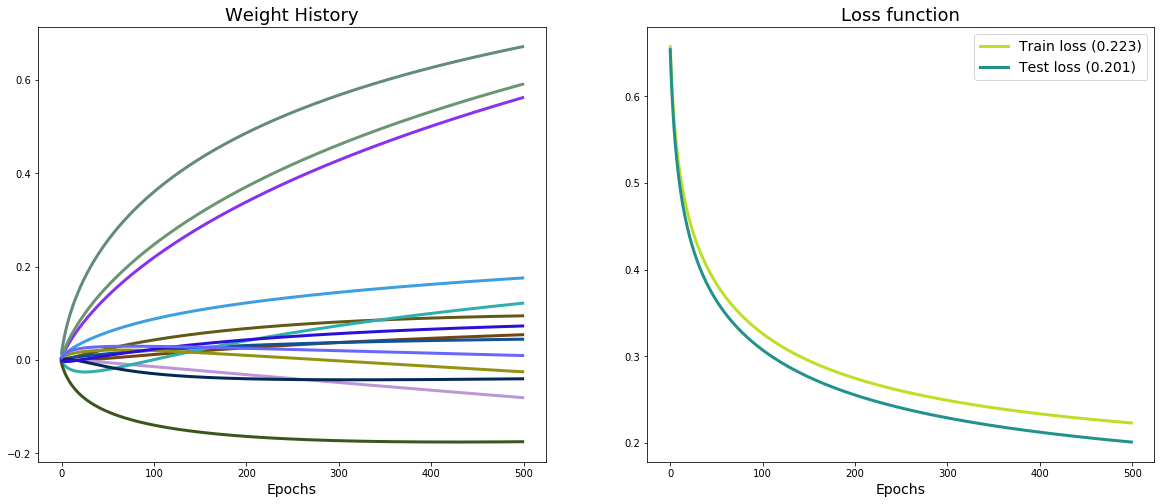

In [263]:
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
plot_weigth(model.named_steps.regressor.coef_history,
            axis[0], legend=False)
plot_loss(model.named_steps.regressor, axis[1])